In [430]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

In [431]:

data=pd.read_csv("./one_room_apartement.csv")

In [432]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,1.995,20.863,6.004,273.935,1.726,23.718,805.0,490.458,1868,518.956,...,758.0,27.774,0.923,26.690,60.385,0.04,12.983,51.839,5.402,859.499
1,1.689,20.863,6.891,296.490,1.726,23.715,806.0,490.505,1867,520.396,...,715.0,27.762,0.739,26.594,60.377,0.03,12.980,52.092,6.451,932.282
2,2.854,20.863,7.486,268.740,1.726,23.716,808.0,489.080,1857,520.139,...,742.0,27.764,3.002,26.501,60.358,0.00,12.977,51.313,6.107,851.850
3,1.635,20.862,5.874,262.821,1.726,23.719,807.0,488.189,1881,518.782,...,746.0,27.748,1.287,26.611,60.426,0.03,12.993,53.420,5.489,829.355
4,1.579,20.864,7.068,297.597,1.725,23.712,809.0,485.401,1880,516.398,...,717.0,27.760,0.527,26.681,60.435,0.03,12.990,52.284,6.723,926.864


In [433]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
12441,2.493,20.842,3.159,139.359,1.578,27.999,738.0,432.277,1799,715.633,...,661.0,32.491,0.652,30.628,47.086,0.00,12.860,59.537,2.733,432.119
12442,2.550,20.843,2.592,151.838,1.577,28.029,738.0,433.938,1782,723.661,...,653.0,32.507,0.590,30.105,47.237,0.08,12.923,59.008,2.277,475.226
12443,2.020,20.840,3.614,163.927,1.575,28.074,741.0,435.733,1804,733.135,...,650.0,32.559,1.847,29.544,47.292,0.31,12.970,59.580,3.254,520.100
12444,2.970,20.841,2.830,130.268,1.573,28.110,746.0,432.326,1799,739.224,...,654.0,32.575,1.636,29.012,47.268,0.36,12.989,59.275,2.154,408.629
12445,5.349,20.840,3.612,122.472,1.573,28.149,745.0,433.729,1786,747.578,...,648.0,32.597,3.106,28.614,47.254,0.23,13.013,59.092,1.747,381.507


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [434]:
print(data)

       TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      1.995  20.863  6.004  273.935  1.726       23.718        805.0   
1      1.689  20.863  6.891  296.490  1.726       23.715        806.0   
2      2.854  20.863  7.486  268.740  1.726       23.716        808.0   
3      1.635  20.862  5.874  262.821  1.726       23.719        807.0   
4      1.579  20.864  7.068  297.597  1.725       23.712        809.0   
...      ...     ...    ...      ...    ...          ...          ...   
12441  2.493  20.842  3.159  139.359  1.578       27.999        738.0   
12442  2.550  20.843  2.592  151.838  1.577       28.029        738.0   
12443  2.020  20.840  3.614  163.927  1.575       28.074        741.0   
12444  2.970  20.841  2.830  130.268  1.573       28.110        746.0   
12445  5.349  20.840  3.612  122.472  1.573       28.149        745.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      490.458         1868  518.956  ...   758

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [435]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','o3','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)

Modifier le nom de timestamp et le convertir en index

In [436]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.tail(10))

                     oxygen   pm10     co  temperature      co2      so2  \
date                                                                       
2023-07-11 10:31:33  20.842  2.670  1.585       28.012  428.491  675.899   
2023-07-11 10:33:36  20.841  2.372  1.585       27.979  431.928  684.438   
2023-07-11 10:35:34  20.840  2.424  1.584       27.970  437.313  688.993   
2023-07-11 10:37:38  20.839  2.162  1.582       27.975  436.153  700.038   
2023-07-11 10:39:38  20.840  2.336  1.580       27.981  434.915  714.911   
2023-07-11 10:41:40  20.842  3.159  1.578       27.999  432.277  715.633   
2023-07-11 10:43:40  20.843  2.592  1.577       28.029  433.938  723.661   
2023-07-11 10:45:42  20.840  3.614  1.575       28.074  435.733  733.135   
2023-07-11 10:47:41  20.841  2.830  1.573       28.110  432.326  739.224   
2023-07-11 10:49:42  20.840  3.612  1.573       28.149  433.729  747.578   

                        no2    pm1   dewpt      tvoc  pressure  humidity  \
date       

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

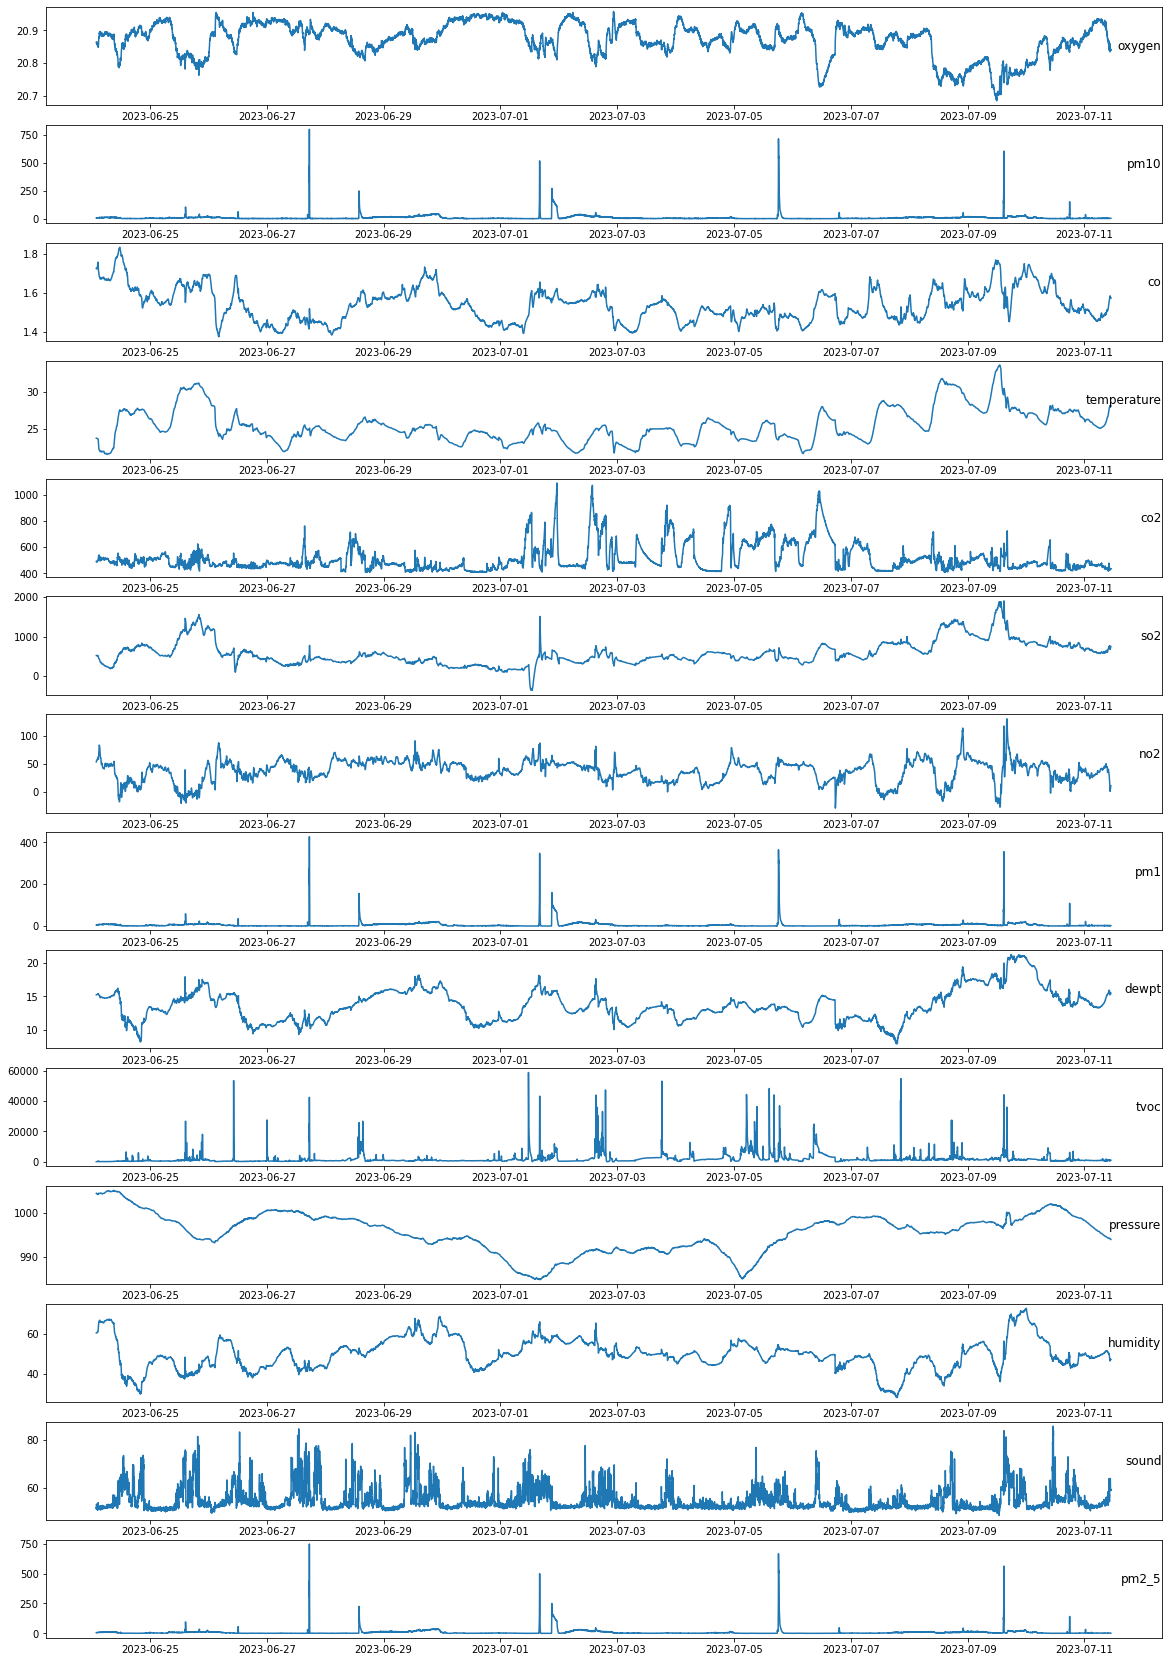

In [437]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

In [438]:
data

,oxygen,pm10,co,temperature,co2,so2,no2,pm1,dewpt,tvoc,pressure,humidity,sound,pm2_5
date,,,,,,,,,,,,,,
2023-06-24 01:59:10,20.863,6.004,1.726,23.718,490.458,518.956,53.683,4.772,15.243,88.673,1004.360,60.385,51.839,5.402
2023-06-24 02:01:10,20.863,6.891,1.726,23.715,490.505,520.396,54.946,5.906,15.239,87.726,1004.340,60.377,52.092,6.451
2023-06-24 02:03:11,20.863,7.486,1.726,23.716,489.080,520.139,55.795,5.004,15.235,98.224,1004.320,60.358,51.313,6.107
2023-06-24 02:05:11,20.862,5.874,1.726,23.719,488.189,518.782,56.146,4.991,15.255,91.344,1004.300,60.426,53.420,5.489
2023-06-24 02:07:11,20.864,7.068,1.725,23.712,485.401,516.398,56.341,5.839,15.251,85.264,1004.280,60.435,52.284,6.723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-11 10:41:40,20.842,3.159,1.578,27.999,432.277,715.633,7.023,2.007,15.321,955.380,993.977,47.086,59.537,2.733
2023-07-11 10:43:40,20.843,2.592,1.577,28.029,433.938,723.661,8.350,1.668,15.398,977.042,993.949,47.237,59.008,2.277
2023-07-11 10:45:42,20.840,3.614,1.575,28.074,435.733,733.135,9.782,2.233,15.457,984.612,993.952,47.292,59.580,3.254


**Multivariate LSTM Predictive Modeling**

In [439]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [440]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [441]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-3,-4,-11]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var2(t),var3(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var13(t),var14(t)
1,0.652016,0.007486,0.763676,0.181498,0.121727,0.389184,0.517380,0.011164,0.549683,0.001507,...,0.008592,0.763676,0.121795,0.389819,0.525309,0.013817,0.549384,0.001491,0.091122,0.008636
2,0.652016,0.008592,0.763676,0.181252,0.121795,0.389819,0.525309,0.013817,0.549384,0.001491,...,0.009334,0.763676,0.119705,0.389705,0.530639,0.011707,0.549085,0.001670,0.069958,0.008175
3,0.652016,0.009334,0.763676,0.181334,0.119705,0.389705,0.530639,0.011707,0.549085,0.001670,...,0.007324,0.763676,0.118399,0.389107,0.532842,0.011677,0.550579,0.001553,0.127201,0.007348
4,0.648346,0.007324,0.763676,0.181580,0.118399,0.389107,0.532842,0.011677,0.550579,0.001553,...,0.008813,0.761488,0.114310,0.388056,0.534066,0.013661,0.550280,0.001449,0.096338,0.009000
5,0.655678,0.008813,0.761488,0.181006,0.114310,0.388056,0.534066,0.013661,0.550280,0.001449,...,0.008857,0.759300,0.112774,0.387212,0.535240,0.011978,0.550205,0.001466,0.083107,0.007897


In [442]:

values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-11].values, train.iloc[:, -11:].values
test_X, test_y = test.iloc[:, :-11].values, test.iloc[:, -11:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(9956, 1, 14) (9956, 11) (2489, 1, 14) (2489, 11)


Define the LSTM model

Il y a 50 neurones dans la première couche cachée et 10 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 13 caractéristiques.

In [443]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(11))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dropout_28 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 11)                561       
Total params: 13,561
Trainable params: 13,561
Non-trainable params: 0
_________________________________________________________________
None


Training the LSTM model

Epoch 1/200
277/277 - 1s - loss: 0.1139 - val_loss: 0.0998
Epoch 2/200
277/277 - 0s - loss: 0.0712 - val_loss: 0.0822
Epoch 3/200
277/277 - 0s - loss: 0.0557 - val_loss: 0.0692
Epoch 4/200
277/277 - 0s - loss: 0.0483 - val_loss: 0.0648
Epoch 5/200
277/277 - 0s - loss: 0.0437 - val_loss: 0.0588
Epoch 6/200
277/277 - 1s - loss: 0.0406 - val_loss: 0.0537
Epoch 7/200
277/277 - 0s - loss: 0.0383 - val_loss: 0.0488
Epoch 8/200
277/277 - 1s - loss: 0.0366 - val_loss: 0.0459
Epoch 9/200
277/277 - 1s - loss: 0.0355 - val_loss: 0.0421
Epoch 10/200
277/277 - 1s - loss: 0.0341 - val_loss: 0.0401
Epoch 11/200
277/277 - 1s - loss: 0.0331 - val_loss: 0.0391
Epoch 12/200
277/277 - 1s - loss: 0.0325 - val_loss: 0.0369
Epoch 13/200
277/277 - 1s - loss: 0.0319 - val_loss: 0.0346
Epoch 14/200
277/277 - 1s - loss: 0.0316 - val_loss: 0.0347
Epoch 15/200
277/277 - 1s - loss: 0.0317 - val_loss: 0.0333
Epoch 16/200
277/277 - 0s - loss: 0.0312 - val_loss: 0.0316
Epoch 17/200
277/277 - 1s - loss: 0.0310 - val_lo

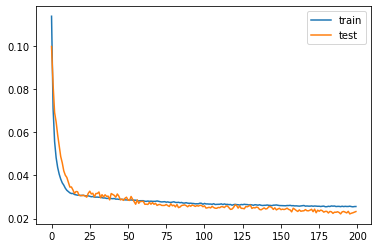

In [444]:
history = model.fit(train_X, train_y, epochs=200, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating LSTM models

             0      1      2          3           4           5          6   \
2484  20.841999  3.159  1.578  21.948790  731.942200  145.319550 -27.984045   
2485  20.843000  2.592  1.577  21.978491  734.355469  164.215469 -28.110382   
2486  20.840000  3.614  1.575  22.010592  737.203308  184.606552 -27.899820   
2487  20.841000  2.830  1.573  21.949665  739.033630  195.101120 -28.003424   
2488  20.840000  3.612  1.573  21.974754  741.544861  201.366562 -28.170382   

              7         8             9           10  
2484  237.441544  8.097864  17231.087891  984.858032  
2485  239.898590  8.102805  16387.011719  984.845703  
2486  241.781296  8.104532  17299.707031  984.872192  
2487  242.579025  8.102149  16813.046875  984.842346  
2488  243.536301  8.105678  16521.044922  984.831299  


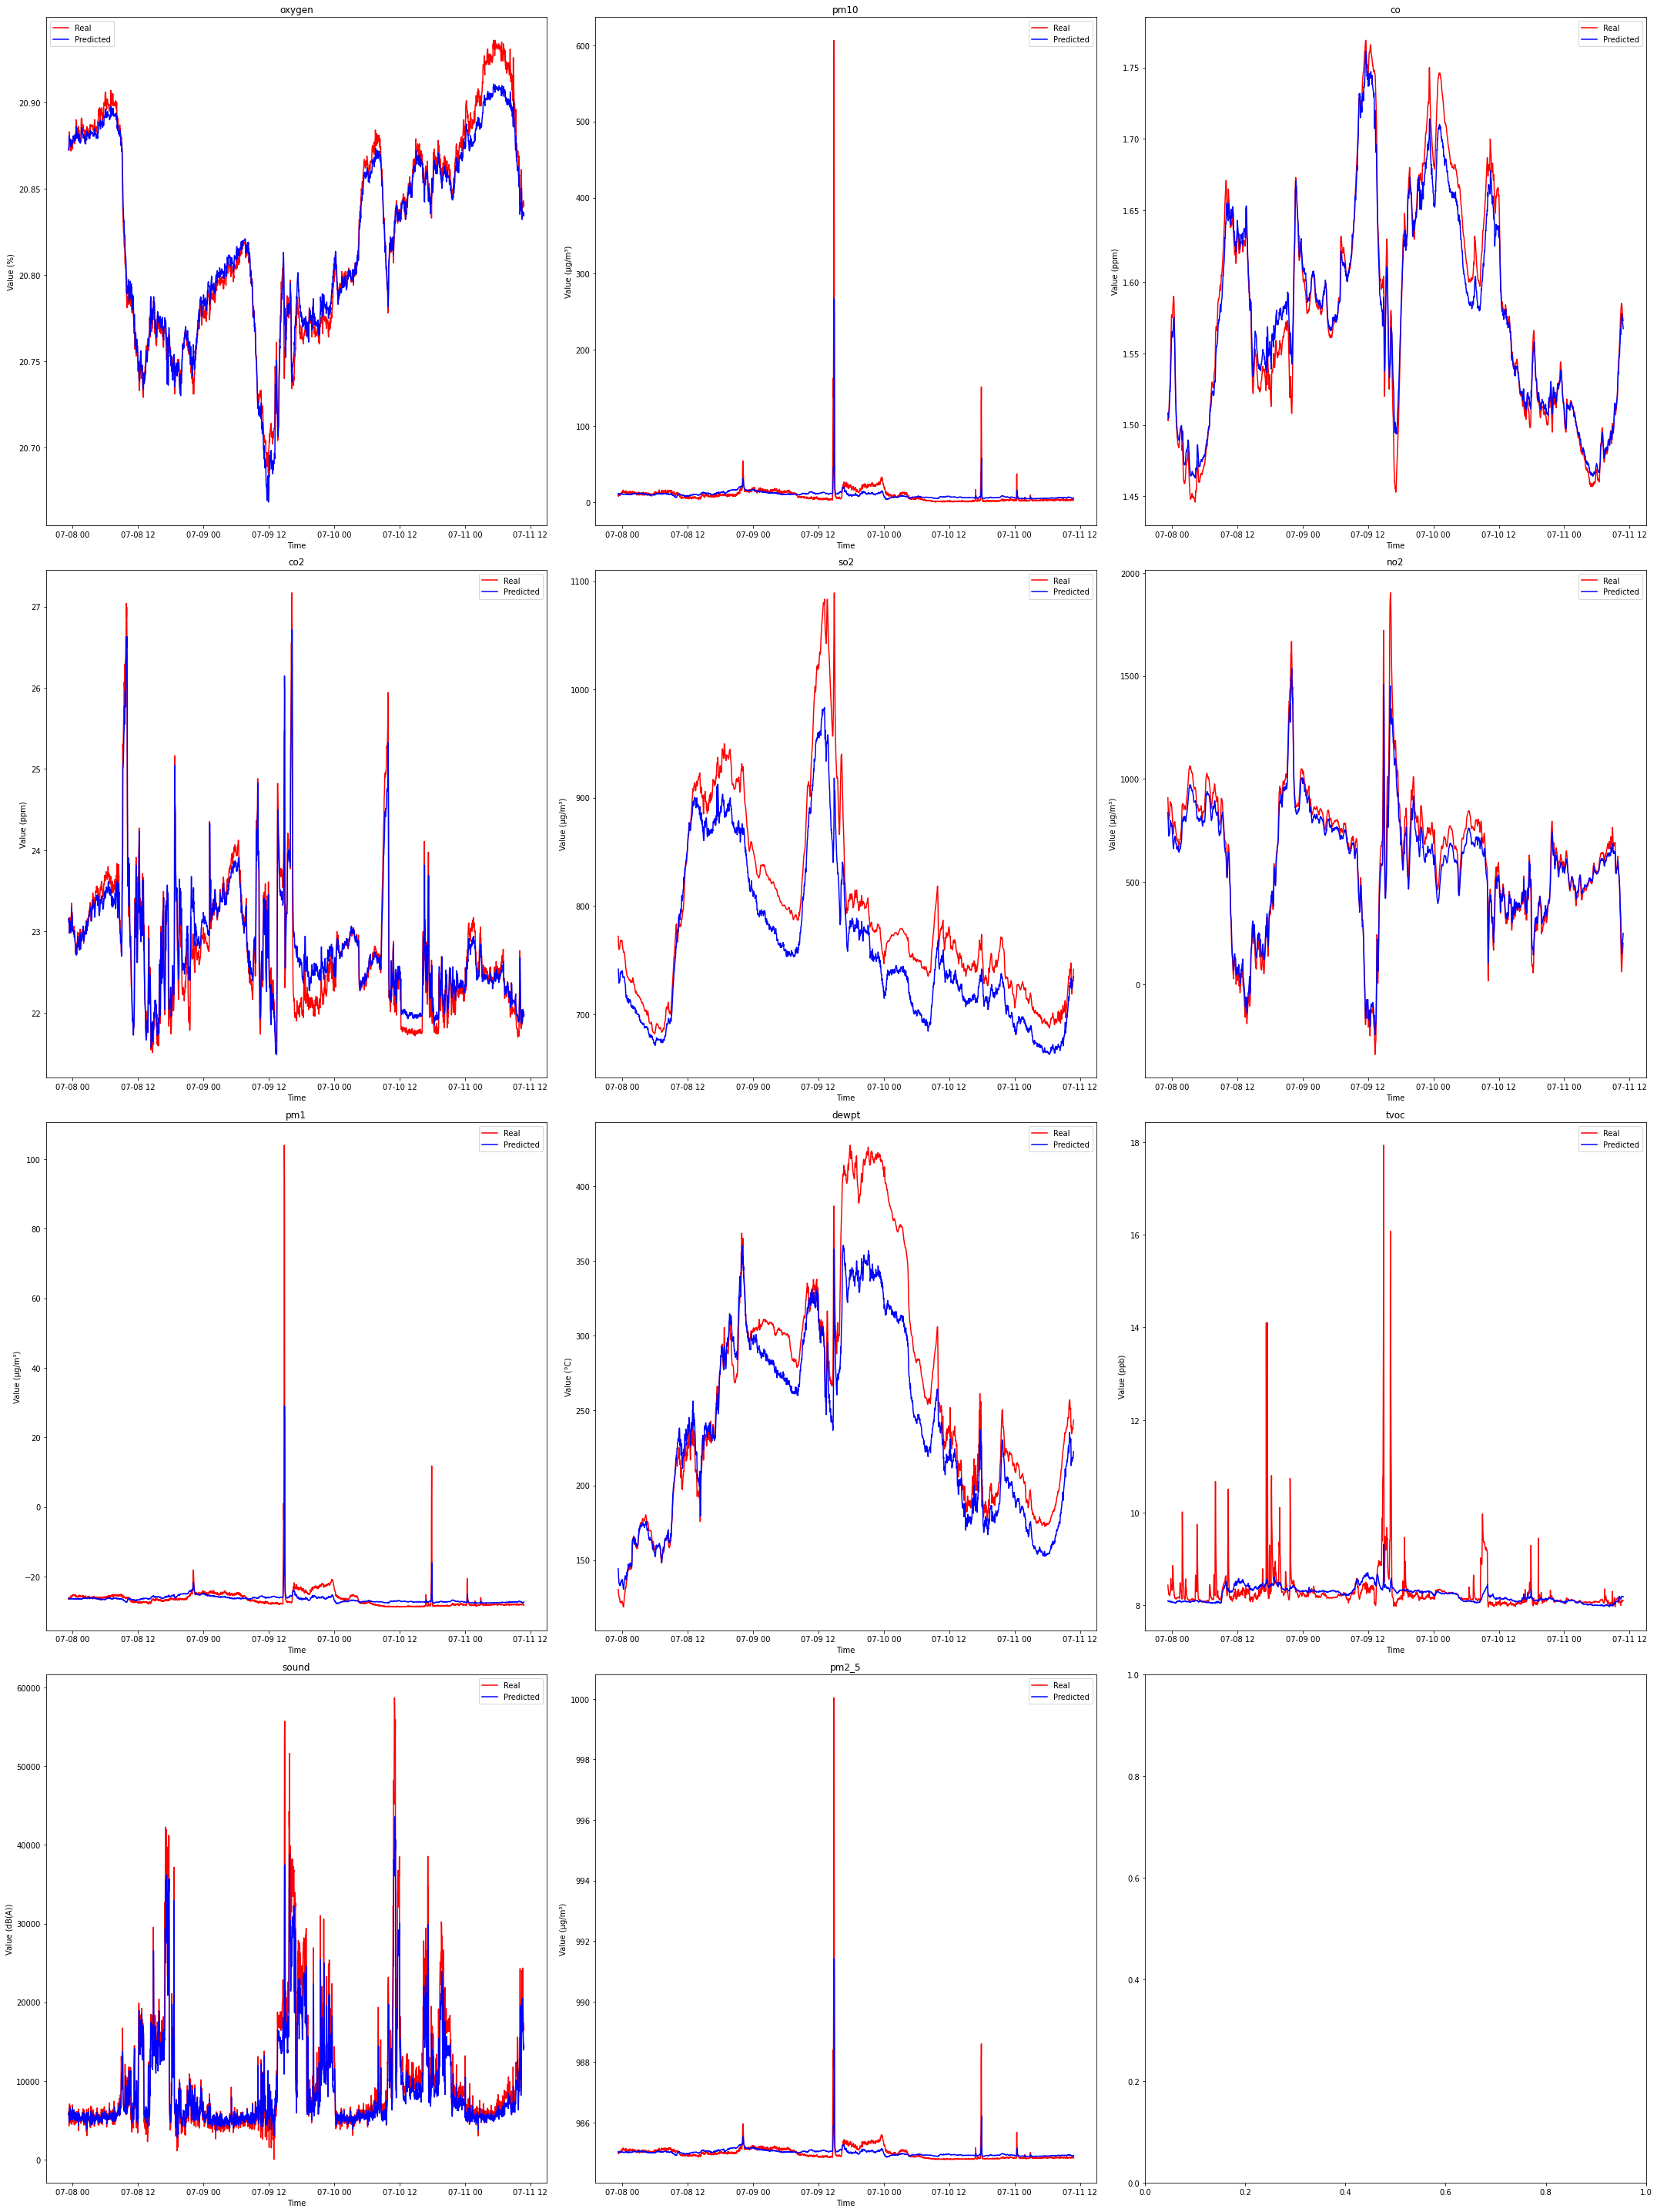

In [445]:

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [3, 10, 11]]
# selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]
inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
# oxygen_predict = inv_yhat[:, 0]
# pm10_predict = inv_yhat[:, 1]
# co_predict = inv_yhat[:, 2]
# co2_predict = inv_yhat[:, 3]
# so2_predict = inv_yhat[:, 4]
# no2_predict = inv_yhat[:, 5]
# pm1_predict = inv_yhat[:, 6]
# dewpt_predict = inv_yhat[:, 7]
# tvoc_predict = inv_yhat[:, 8]
# pm2_5_predict = inv_yhat[:, 9]

test_y = test_y.reshape((len(test_y), 11))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.tail())
# oxygen_reel = inv_y[:, 0]
# pm10_reel = inv_y[:, 1]
# co_reel = inv_y[:, 2]
# co2_reel = inv_y[:, 3]
# so2_reel = inv_y[:, 4]
# no2_reel = inv_y[:, 5]
# pm1_reel = inv_y[:, 6]
# dewpt_reel = inv_y[:, 7]
# tvoc_reel = inv_y[:, 8]
# pm2_5_reel = inv_y[:, 9]

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)
# zgelikais
dates = dates[-2489:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'sound': 9, 'pm2_5': 10
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
    axs[row, col].legend()

plt.tight_layout()
plt.show()


In [446]:
print(inv_y.shape, inv_yhat.shape)
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [11, 12, 13]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

(2489, 11) (2489, 11)
Test RMSE for oxygen: 0.009
Test RMSE for pm10: 14.723
Test RMSE for co: 0.014
Test RMSE for co2: 0.258
Test RMSE for so2: 39.102
Test RMSE for no2: 68.178
Test RMSE for pm1: 3.234
Test RMSE for dewpt: 32.232
Test RMSE for tvoc: 0.503
Test RMSE for sound: 3334.475
Test RMSE for pm2_5: 0.364


In [447]:
data['IAQ'] = (data['pm1']<=10) & (data['pm2_5']<=25) & (data['pm10']<=50) & (data['co2']<800) & (data['tvoc']<300) 
data['IAQ'] = data['IAQ'].astype(object).replace({False:'POOR', True:'GOOD'})

In [448]:
data

,oxygen,pm10,co,temperature,co2,so2,no2,pm1,dewpt,tvoc,pressure,humidity,sound,pm2_5,IAQ
date,,,,,,,,,,,,,,,
2023-06-24 01:59:10,20.863,6.004,1.726,23.718,490.458,518.956,53.683,4.772,15.243,88.673,1004.360,60.385,51.839,5.402,GOOD
2023-06-24 02:01:10,20.863,6.891,1.726,23.715,490.505,520.396,54.946,5.906,15.239,87.726,1004.340,60.377,52.092,6.451,GOOD
2023-06-24 02:03:11,20.863,7.486,1.726,23.716,489.080,520.139,55.795,5.004,15.235,98.224,1004.320,60.358,51.313,6.107,GOOD
2023-06-24 02:05:11,20.862,5.874,1.726,23.719,488.189,518.782,56.146,4.991,15.255,91.344,1004.300,60.426,53.420,5.489,GOOD
2023-06-24 02:07:11,20.864,7.068,1.725,23.712,485.401,516.398,56.341,5.839,15.251,85.264,1004.280,60.435,52.284,6.723,GOOD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-11 10:41:40,20.842,3.159,1.578,27.999,432.277,715.633,7.023,2.007,15.321,955.380,993.977,47.086,59.537,2.733,POOR
2023-07-11 10:43:40,20.843,2.592,1.577,28.029,433.938,723.661,8.350,1.668,15.398,977.042,993.949,47.237,59.008,2.277,POOR
2023-07-11 10:45:42,20.840,3.614,1.575,28.074,435.733,733.135,9.782,2.233,15.457,984.612,993.952,47.292,59.580,3.254,POOR


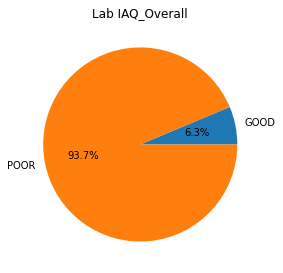

In [449]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(np.unique(data['IAQ'].values, return_counts=True)[1]/len(data), labels=np.unique(data['IAQ'].values, return_counts=True)[0], autopct='%.1f%%')
ax.set_title('Lab IAQ_Overall')
plt.tight_layout()

anticiper

In [450]:
n_seconds = 7
n_features = 14

reframed = series_to_supervised(scaled, n_seconds, 1)

In [451]:
reframed.drop(reframed.columns[[-3,-4,-11]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var2(t),var3(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var13(t),var14(t)
7,0.652016,0.007486,0.763676,0.181498,0.121727,0.389184,0.517380,0.011164,0.549683,0.001507,...,0.008789,0.757112,0.115279,0.385335,0.533991,0.012343,0.550429,0.001476,0.094463,0.008455
8,0.652016,0.008592,0.763676,0.181252,0.121795,0.389819,0.525309,0.013817,0.549384,0.001491,...,0.009619,0.759300,0.115752,0.384858,0.534386,0.014250,0.551549,0.001593,0.072131,0.009624
9,0.652016,0.009334,0.763676,0.181334,0.119705,0.389705,0.530639,0.011707,0.549085,0.001670,...,0.008591,0.761488,0.119245,0.384773,0.536508,0.012694,0.552296,0.001630,0.093703,0.008112
10,0.648346,0.007324,0.763676,0.181580,0.118399,0.389107,0.532842,0.011677,0.550579,0.001553,...,0.009048,0.761488,0.119999,0.385144,0.537387,0.013036,0.551400,0.002238,0.084384,0.009314
11,0.655678,0.008813,0.761488,0.181006,0.114310,0.388056,0.534066,0.013661,0.550280,0.001449,...,0.007789,0.768053,0.121418,0.386124,0.539101,0.012603,0.552146,0.003386,0.089274,0.008089
12,0.655678,0.008857,0.759300,0.180431,0.112774,0.387212,0.535240,0.011978,0.550205,0.001466,...,0.009407,0.772429,0.125503,0.386923,0.541926,0.012919,0.552520,0.003392,0.072837,0.009522
13,0.655678,0.008218,0.759300,0.180431,0.112717,0.386141,0.534776,0.012386,0.550280,0.001472,...,0.008095,0.776805,0.123783,0.387452,0.544192,0.012776,0.552818,0.003172,0.078108,0.008471
14,0.652016,0.008789,0.757112,0.180513,0.115279,0.385335,0.533991,0.012343,0.550429,0.001476,...,0.009595,0.781182,0.132610,0.387680,0.547701,0.015163,0.555431,0.002926,0.062160,0.009887
15,0.655678,0.009619,0.759300,0.180349,0.115752,0.384858,0.534386,0.014250,0.551549,0.001593,...,0.009814,0.783370,0.134140,0.387311,0.550457,0.014709,0.556178,0.002631,0.074957,0.009942
16,0.655678,0.008591,0.761488,0.180349,0.119245,0.384773,0.536508,0.012694,0.552296,0.001630,...,0.009958,0.792123,0.131066,0.387344,0.552108,0.015106,0.555804,0.002414,0.086938,0.010300


In [452]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_seconds * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(9956, 98) (9956, 11) (2483, 98) (2483, 11)


In [453]:
train_X = train_X.reshape((train_X.shape[0], n_seconds, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seconds, n_features))

print(test_X.shape,train_X.shape)

(2483, 7, 14) (9956, 7, 14)


In [454]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(11))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dropout_29 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 11)                561       
Total params: 13,561
Trainable params: 13,561
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/200
277/277 - 1s - loss: 0.1121 - val_loss: 0.0841
Epoch 2/200
277/277 - 1s - loss: 0.0658 - val_loss: 0.0708
Epoch 3/200
277/277 - 1s - loss: 0.0516 - val_loss: 0.0564
Epoch 4/200
277/277 - 1s - loss: 0.0442 - val_loss: 0.0515
Epoch 5/200
277/277 - 2s - loss: 0.0404 - val_loss: 0.0465
Epoch 6/200
277/277 - 2s - loss: 0.0380 - val_loss: 0.0473
Epoch 7/200
277/277 - 1s - loss: 0.0365 - val_loss: 0.0460
Epoch 8/200
277/277 - 1s - loss: 0.0351 - val_loss: 0.0411
Epoch 9/200
277/277 - 1s - loss: 0.0338 - val_loss: 0.0409
Epoch 10/200
277/277 - 1s - loss: 0.0335 - val_loss: 0.0411
Epoch 11/200
277/277 - 1s - loss: 0.0331 - val_loss: 0.0372
Epoch 12/200
277/277 - 1s - loss: 0.0324 - val_loss: 0.0364
Epoch 13/200
277/277 - 2s - loss: 0.0321 - val_loss: 0.0353
Epoch 14/200
277/277 - 1s - loss: 0.0325 - val_loss: 0.0376
Epoch 15/200
277/277 - 2s - loss: 0.0320 - val_loss: 0.0348
Epoch 16/200
277/277 - 1s - loss: 0.0316 - val_loss: 0.0355
Epoch 17/200
277/277 - 1s - loss: 0.0314 - val_lo

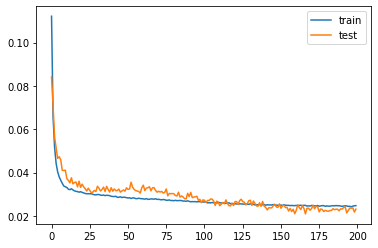

In [455]:
history = model.fit(train_X, train_y, epochs=200, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

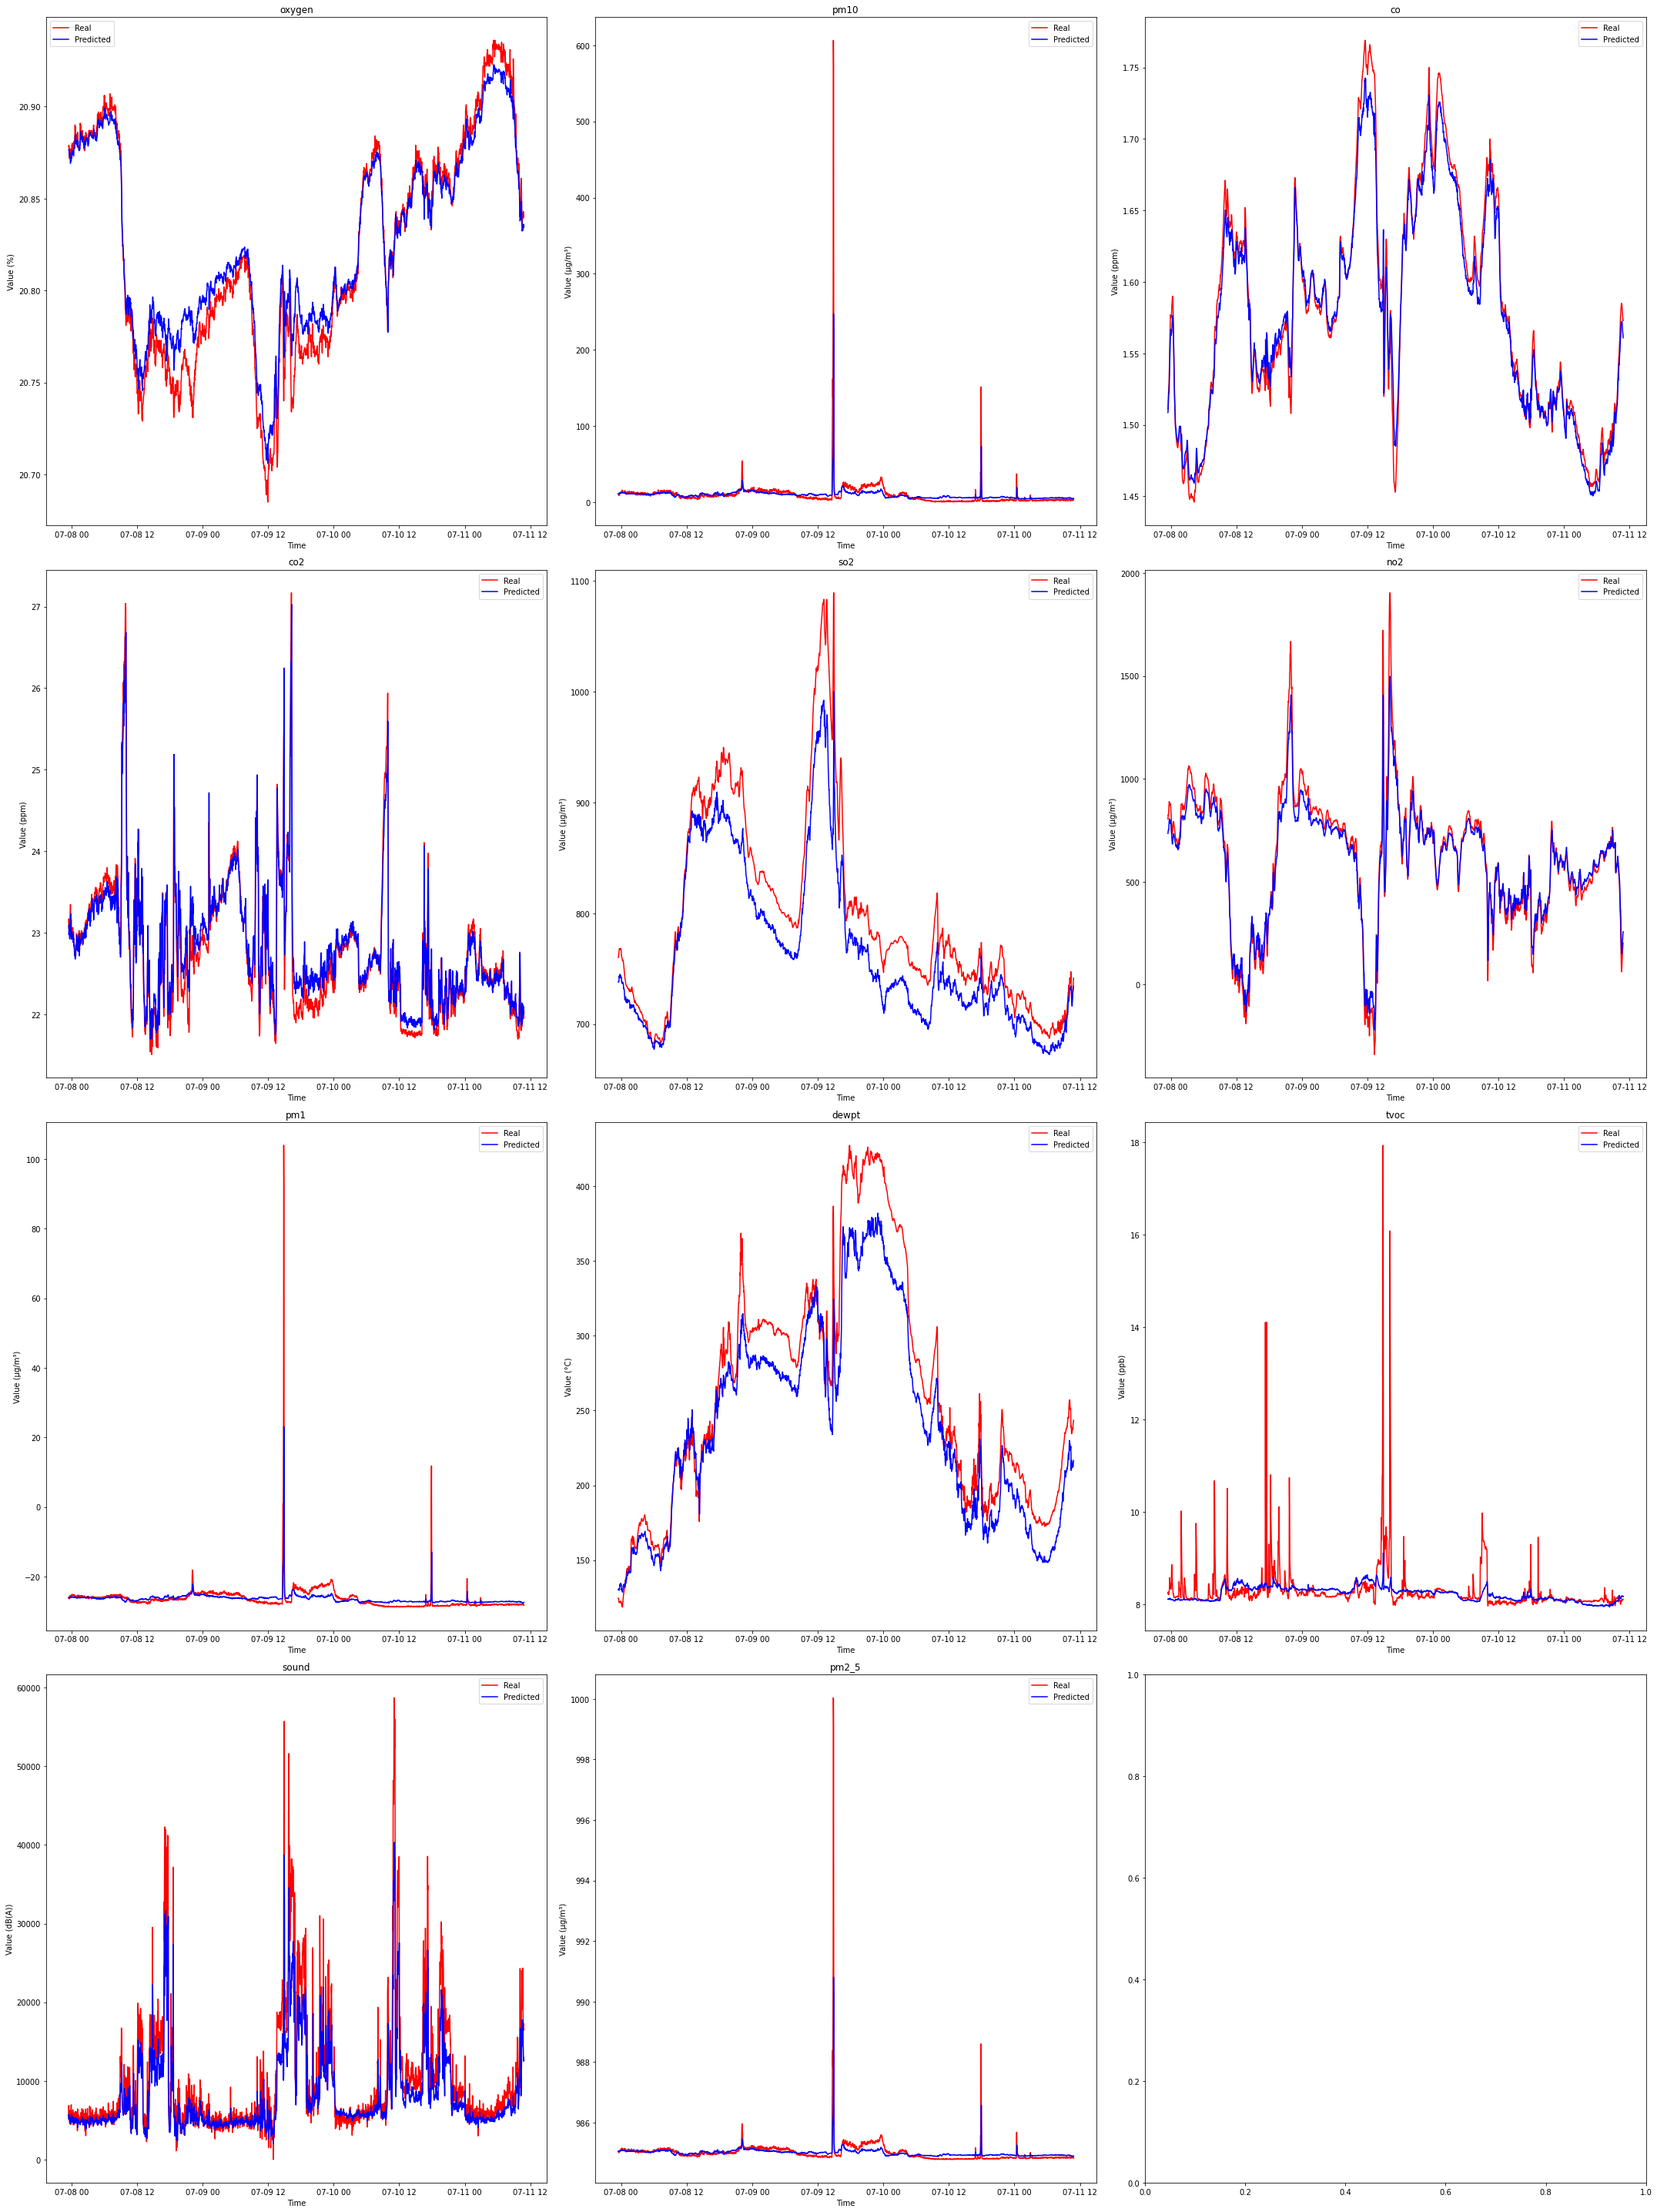

In [456]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [3, 10, 11]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns2]

test_y = test_y.reshape((len(test_y), 11))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, selected_columns2]

dates = dates[-2483:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'sound': 9, 'pm2_5': 10
}
feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
    axs[row, col].legend()

plt.tight_layout()
plt.show()


In [457]:
print(inv_y.shape, inv_yhat.shape)

(2483, 14) (2483, 14)


In [458]:
selected_columns2 = [i for i in range(inv_y.shape[1]) if i not in [11, 12, 13]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]

In [459]:
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    print(f'Test RMSE for {feature}: {rmse:.3f}')

Test RMSE for oxygen: 0.013
Test RMSE for pm10: 14.738
Test RMSE for co: 0.012
Test RMSE for co2: 0.220
Test RMSE for so2: 35.652
Test RMSE for no2: 63.422
Test RMSE for pm1: 3.267
Test RMSE for dewpt: 26.241
Test RMSE for tvoc: 0.506
Test RMSE for sound: 3961.424
Test RMSE for pm2_5: 0.368
